# EEG Cognitive State Classification with Deep Learning

This project implements and evaluates deep learning models (EEGNet and TSCeption) for classifying cognitive states from EEG data sourced from the Mental Arithmetic Tasks Dataset. The analysis includes power spectral density (PSD) comparison and binary classification using advanced techniques, aiming to contribute insights into EEG-based cognitive state assessment.


## Content:

1. Introduction (Theory/ Goal/ Approach)
2. Get Familarize with the data
3. Power Spectral Density Analysis
4. Deep learning classification
   - EEGNet model
   - Vision Transformer


#### EEG Net Architecture


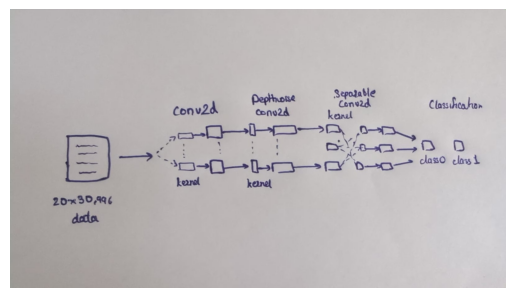

In [1]:
import cv2
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('EEGNet2.jpg')

# Convert BGR image to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()

#### Vision Transformer


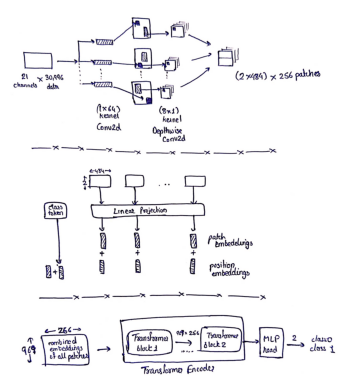

In [2]:
# Read the image
image = cv2.imread('ViT architecture.png')

# Convert BGR image to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()


### 1. Introduction


**Electroencephalography (EEG)** is a technique used to record electrical activity in the brain. It's a non-invasive method that involves placing electrodes on the scalp to detect and measure the electrical signals generated by neurons firing within the brain.<br>
**Power Spectral Density(PSD)** analysis involves examining the distribution of signal power across specific frequency bands in EEG data. By comparing these distributions between rest and task states, insights into distinct brain activity patterns emerge, crucial for accurate cognitive state classification.

- **EEG Works**:

  - Electrodes Placement: Small metal discs (electrodes) are placed on the scalp in a specific pattern (montage) and connected to the EEG machine.

  - Signal Detection: Electrodes detect weak electrical signals generated by neuron activity in the brain (0.5 to 100 microvolts).

  - Amplification and Recording: EEG machine amplifies and records these signals continuously or in segments for analysis.

  - Data Analysis: Analyzing recorded EEG data reveals frequency components (delta, theta, alpha, beta, gamma waves) and their scalp distribution, aiding study of brain function and cognition.<br><br>

- **PSD**:

  - **Frequency Band Analysis**: PSD analysis involves calculating the distribution of signal power across different frequency bands—Delta (1-4 Hz), Theta (4-8 Hz), Alpha (8-12 Hz), Beta (12-30 Hz), and Gamma (30-100 Hz). This analysis helps in understanding how brain activity varies between resting and task-engaged states, providing insights into cognitive processes.

  - **Comparative Analysis**: By comparing the PSDs of EEG signals recorded during rest and mental arithmetic tasks, you can identify frequency band differences. These differences may indicate distinct patterns of brain activity associated with different cognitive states, facilitating the development of effective classification models.<br><br>

- **Goal**: <br>The aim of this study is to utilize deep learning models like EEGNet and TSCeption for classifying cognitive states from EEG data obtained from the Mental Arithmetic Tasks Dataset. By implementing these models, the we seek to accurately differentiate between rest and task states based on EEG signals. <br><br>
- **Approach**:
  - Load and preprocess the data
  - Perform Power Spectral Density(PSD) Analysis
  - Feature Extraction
  - Model Implementation
  - Performance Evaluation<br><br>
- **Dataset Overview**: <br>
  The dataset features EEG recordings from 36 healthy volunteers performing serial subtraction tasks. Recorded using a Neurocom EEG 23-channel system, electrodes were placed on the scalp per the International 10/20 scheme, referenced to interconnected ear electrodes. Data includes both rest states and task periods, with preprocessing involving 60-second artifact-free segments and Independent Component Analysis (ICA) for artifact removal. Participants completed trials involving 4-digit minuends and 2-digit subtrahends, categorized based on task accuracy and completion rates. The dataset follows the Brain Imaging Data Structure (BIDS), ensuring standardized analysis and sharing in neuroscience research.


### 2. Get Familarize with the data


In [3]:
import mne
import numpy as np

import os

import matplotlib.pyplot as plt

In [4]:
raw = mne.io.read_raw_edf(
    '.\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00_1.edf', preload=True)
# preload = True, will load the data from edf file into memory immediately upon reading

# All recordings are artifact-free EEG segments so processing is done so no Independent Component Analysis (ICA) to be used

Extracting EDF parameters from c:\Users\Atharva\Documents\GitHub\Main_Projects\main_project_EEG\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


In [5]:
raw.get_data().shape

(21, 91000)

Sampling frequency: 500.0 Hz
Highpass filter: 0.5 Hz
Lowpass filter: 45.0 Hz
Number of channels: 21
Channel names: ['EEG Fp1', 'EEG Fp2', 'EEG F3', 'EEG F4', 'EEG F7', 'EEG F8', 'EEG T3', 'EEG T4', 'EEG C3', 'EEG C4', 'EEG T5', 'EEG T6', 'EEG P3', 'EEG P4', 'EEG O1', 'EEG O2', 'EEG Fz', 'EEG Cz', 'EEG Pz', 'EEG A2-A1', 'ECG ECG']
Data duration: 182.0 seconds
Using matplotlib as 2D backend.


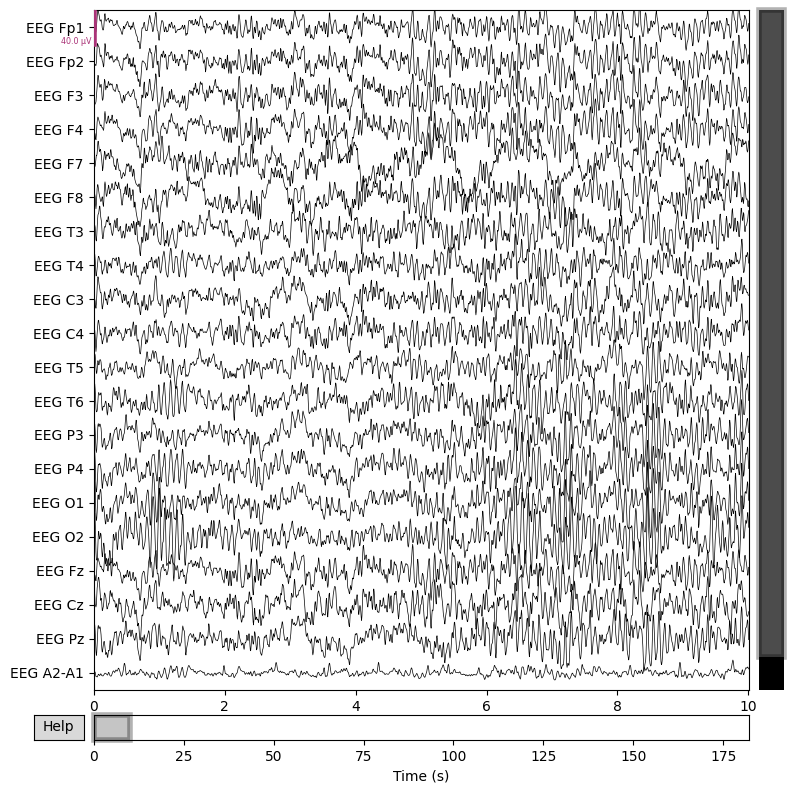

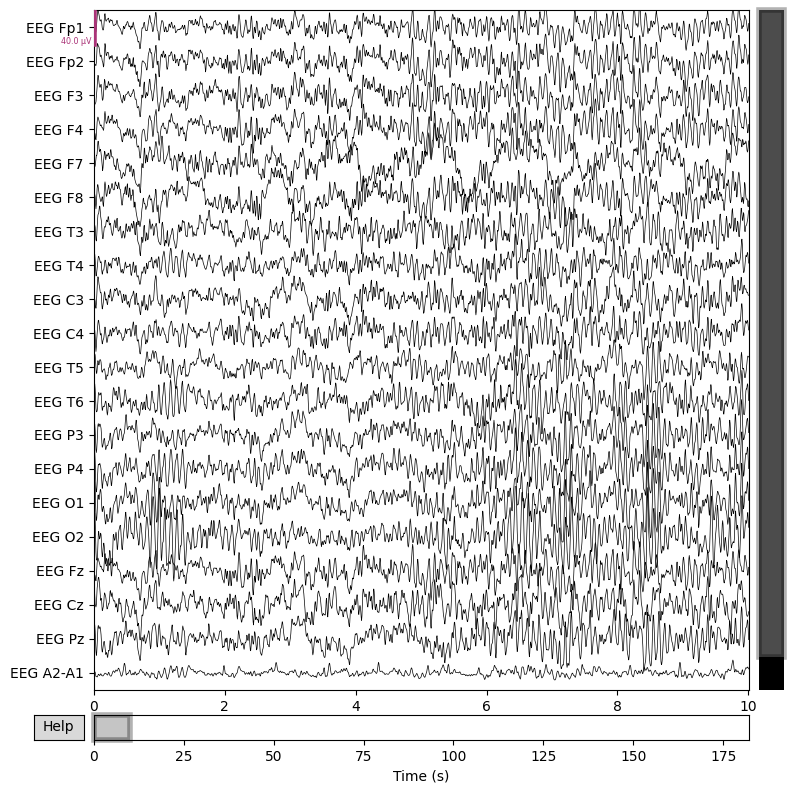

In [6]:
s_freq = raw.info['sfreq']
highpass = raw.info['highpass']
lowpass = raw.info['lowpass']
n_channels = len(raw.info['ch_names'])
channel_names = raw.info['ch_names']

# Print basic information
print("Sampling frequency:", raw.info['sfreq'], "Hz")
print("Highpass filter:", raw.info['highpass'], "Hz")
print("Lowpass filter:", raw.info['lowpass'], "Hz")

# Additional key insights
print("Number of channels:", len(raw.info['ch_names']))
print("Channel names:", raw.info['ch_names'])
print("Data duration:", raw.n_times / raw.info['sfreq'], "seconds")

# Example of plotting EEG data
raw.plot()

### 3. Power Spectral Density Analysis


##### Get data, calculate PSD


In [7]:
from scipy import signal

rest_filepaths = []
task_filepaths = []

directory = './eeg-during-mental-arithmetic-tasks-1.0.0/'
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    if filename.endswith('.edf'):
        label = filename.split('_')[-1].split('.')[0]
        if label == '1':
            rest_filepaths.append(filepath)
        else:
            task_filepaths.append(filepath)

In [8]:
def get_avg_PSD_for_a_candidate(filepath):
    raw = mne.io.read_raw_edf(filepath, preload=True)
    data = raw.get_data()

    F = []
    PSD = []

    for i in range(raw.get_data().shape[0]):
        data_channel = data[i]
        channel_array = np.array(data_channel, dtype=float)
        length = len(channel_array)
        fs = 500

        freq, psd = signal.welch(channel_array, fs, nperseg=2048)
        F.append(freq)
        PSD.append(psd)

    avg_freq = np.mean(F, axis=0)
    avg_psd = np.mean(PSD, axis=0)

    return avg_freq, avg_psd

In [9]:
%%capture
rest_F, rest_PSD = [], []

for filename in rest_filepaths:
    F, PSD = get_avg_PSD_for_a_candidate(filename)
    rest_F.append(F)
    rest_PSD.append(PSD)
    
task_F, task_PSD = [], []

for filename in task_filepaths:
    F, PSD = get_avg_PSD_for_a_candidate(filename)
    task_F.append(F)
    task_PSD.append(PSD)

##### Average PSD of All Channels of Each Candidate Plot


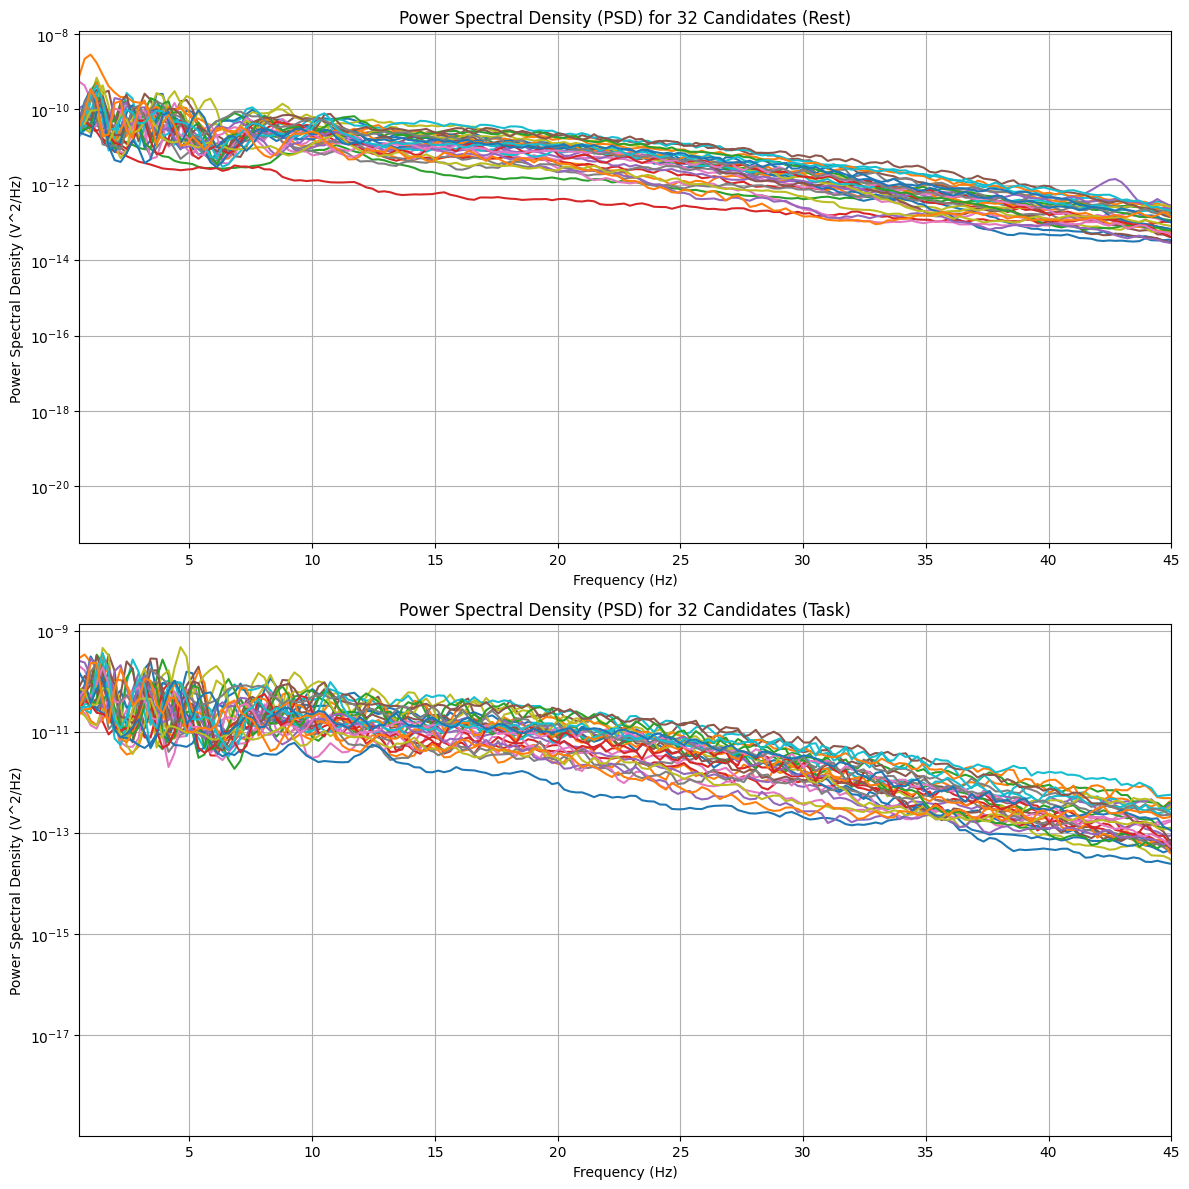

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# First subplot (Rest)
for i in range(32):  # Assuming you have 32 channels
    axs[0].semilogy(rest_F[i], rest_PSD[i])

axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_xlim([0.5, 45])
axs[0].set_ylabel('Power Spectral Density (V^2/Hz)')
axs[0].set_title('Power Spectral Density (PSD) for 32 Candidates (Rest)')
axs[0].grid(True)

# Second subplot (Task)
for i in range(32):  # Assuming you have 32 channels
    axs[1].semilogy(task_F[i], task_PSD[i])

axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_xlim([0.5, 45])
axs[1].set_ylabel('Power Spectral Density (V^2/Hz)')
axs[1].set_title('Power Spectral Density (PSD) for 32 Candidates (Task)')
axs[1].grid(True)

plt.tight_layout()
plt.show()

##### Average PSD of all Channels for All Candidates


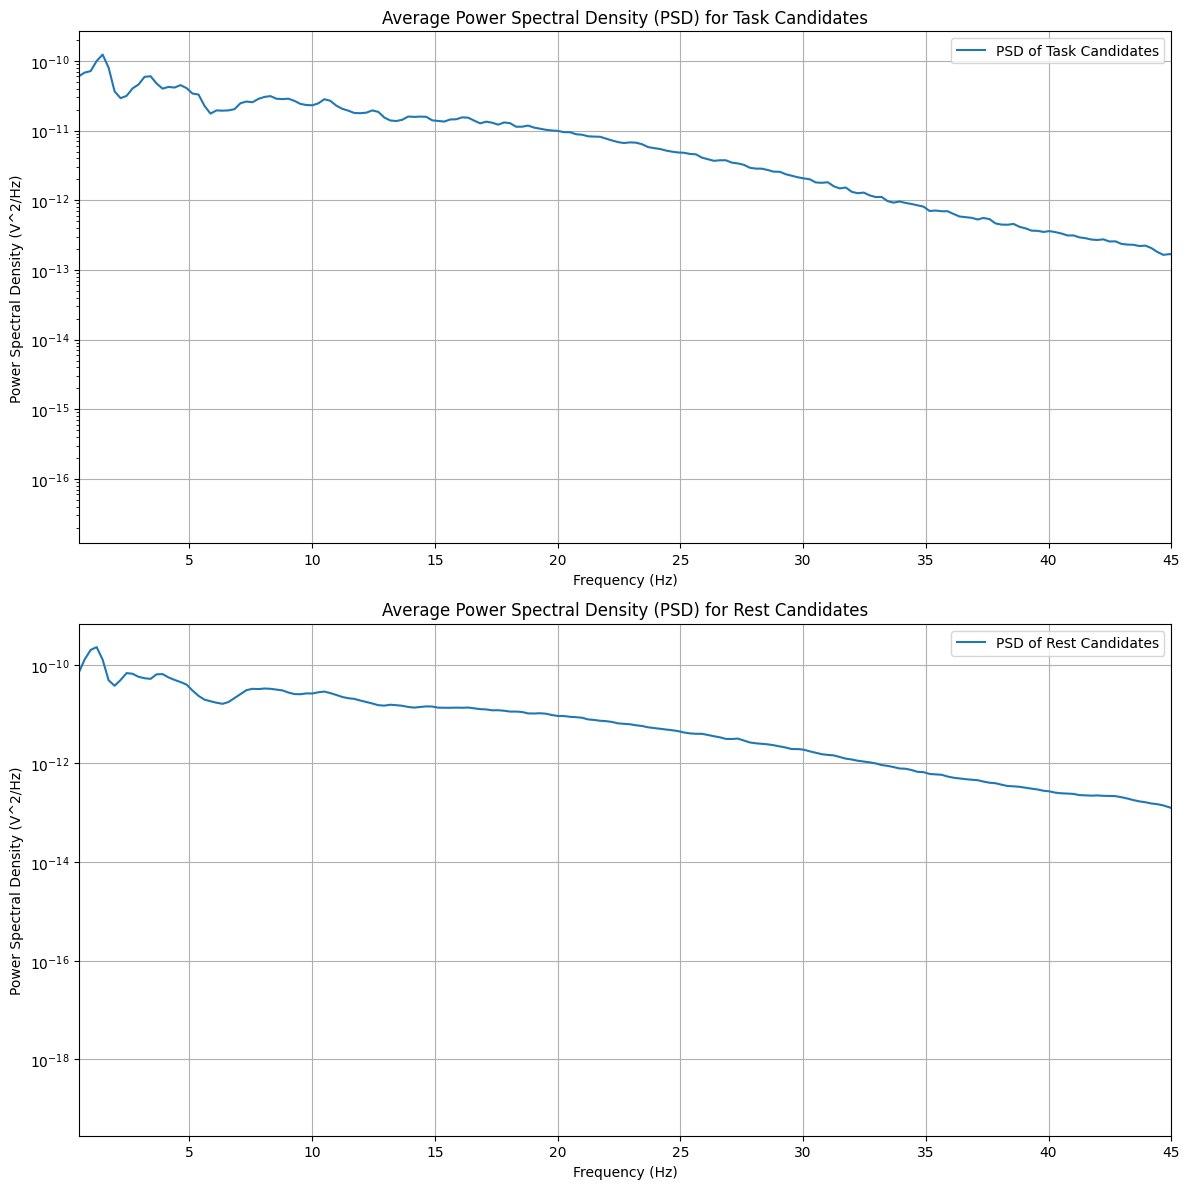

In [11]:
# Calculate the average PSD and frequency values for task and rest conditions
final_task_F = np.mean(task_F, axis=0)
final_task_PSD = np.mean(task_PSD, axis=0)
final_rest_F = np.mean(rest_F, axis=0)
final_rest_PSD = np.mean(rest_PSD, axis=0)

fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# First subplot (Average PSD for Task)
axs[0].semilogy(final_task_F, final_task_PSD, label='PSD of Task Candidates')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_xlim([0.5, 45])
axs[0].set_ylabel('Power Spectral Density (V^2/Hz)')
axs[0].set_title('Average Power Spectral Density (PSD) for Task Candidates')
axs[0].grid(True)
axs[0].legend(loc='upper right')

# Second subplot (Average PSD for Rest)
axs[1].semilogy(final_rest_F, final_rest_PSD, label='PSD of Rest Candidates')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_xlim([0.5, 45])
axs[1].set_ylabel('Power Spectral Density (V^2/Hz)')
axs[1].set_title('Average Power Spectral Density (PSD) for Rest Candidates')
axs[1].grid(True)
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()


##### Frequency Bands

- By observing above plots we divide the frequency into some important bands


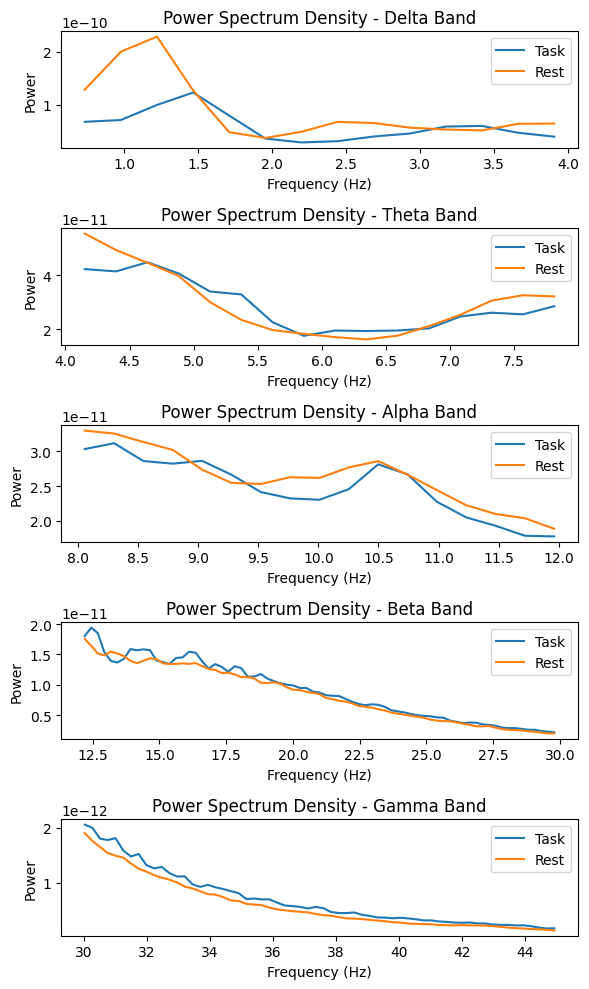

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have final data arrays like final_task_F, final_task_PSD, final_rest_F, final_rest_PSD

# Define frequency bands
freq_bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 45)
}

# Function to extract power in specified frequency bands


def extract_band_power(freqs, psd, bands):
    band_power = {}
    for band, (low, high) in bands.items():
        indices = np.where((freqs >= low) & (freqs < high))[0]
        band_power[band] = np.mean(psd[indices])
    return band_power


# Compute band powers for task and rest conditions
bands_power_task = extract_band_power(final_task_F, final_task_PSD, freq_bands)
bands_power_rest = extract_band_power(final_rest_F, final_rest_PSD, freq_bands)

# Plotting each band separately
plt.figure(figsize=(6, 10))

# Plot individual bands
for i, (band, (low, high)) in enumerate(freq_bands.items(), 1):
    plt.subplot(len(freq_bands), 1, i)

    # Task condition
    indices_task = np.where((final_task_F >= low) & (final_task_F < high))[0]
    plt.plot(final_task_F[indices_task],
             final_task_PSD[indices_task], label='Task')

    # Rest condition
    indices_rest = np.where((final_rest_F >= low) & (final_rest_F < high))[0]
    plt.plot(final_rest_F[indices_rest],
             final_rest_PSD[indices_rest], label='Rest')

    plt.title(f'Power Spectrum Density - {band} Band')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.legend()

plt.tight_layout()
plt.show()



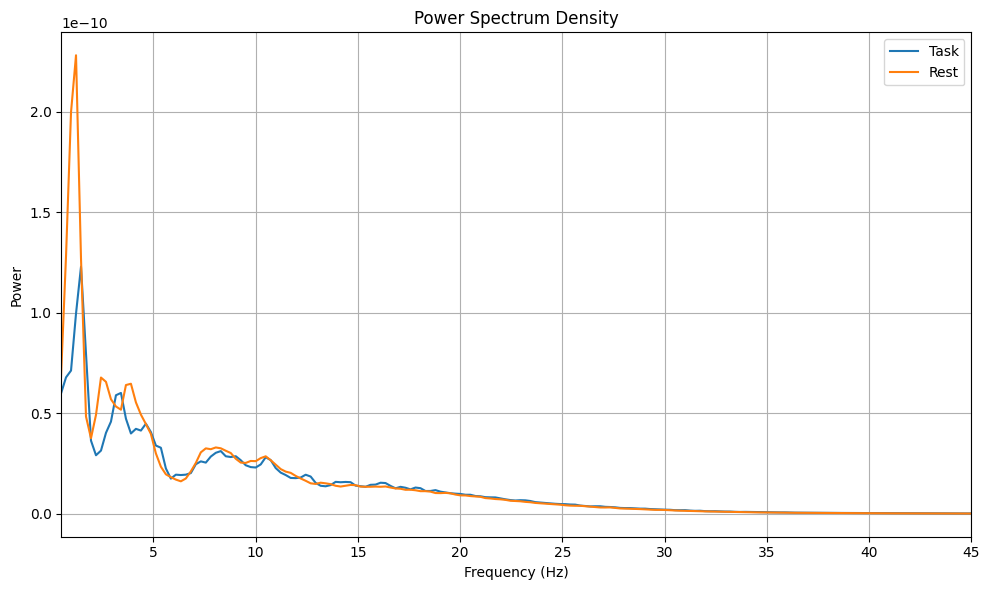

In [13]:
# Plotting power vs frequency
plt.figure(figsize=(10, 6))

# Task condition
plt.plot(final_task_F, final_task_PSD, label='Task')
# Rest condition
plt.plot(final_rest_F, final_rest_PSD, label='Rest')
plt.xlim([0.5, 45])
plt.title('Power Spectrum Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Analysis:


1. The comparison of Power Spectral Density (PSD) between the rest and task states reveals distinct differences in brain activity across various frequency bands.
2. During the task state, increased activity is observed in the Beta (12-30 Hz) and Gamma (30-100 Hz) bands, which are associated with active cognitive processing and attention.
3. The rest state shows higher activity in the Delta (1-4 Hz) and Theta (4-8 Hz) bands, typically linked to relaxation and reduced cognitive load.
4. The Alpha band (8-12 Hz) displays moderate activity in both states but tends to be slightly higher during rest, reflecting a more relaxed yet alert state.
5. These findings align with the expected physiological responses to cognitive tasks and rest periods.


### 4. Deep learning classification


##### Prepare Data


In [14]:
import mne
import numpy as np

import os

import matplotlib.pyplot as plt

from sklearn.utils import resample

In [15]:
directory = './eeg-during-mental-arithmetic-tasks-1.0.0/'

rest_filepaths = []
task_filepaths = []

for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    if filename.endswith('.edf'):
        label = filename.split('_')[-1].split('.')[0]

        if label == '1':
            rest_filepaths.append(filepath)
        else:
            task_filepaths.append(filepath)

In [16]:
def read_data(filepath):
    data = mne.io.read_raw_edf(filepath, preload=True)
    data.set_eeg_reference()
    data.filter(l_freq=0.5, h_freq=45)
    
    tmin, tmax = 0, 61.99
    data.crop(tmin=tmin, tmax=tmax)

    return data.get_data()

In [17]:
%%capture
rest_epochs_array = [read_data(filepath) for filepath in rest_filepaths]
task_epochs_array = [read_data(filepath) for filepath in task_filepaths]

rest_epochs_array = np.array(rest_epochs_array)
task_epochs_array = np.array(task_epochs_array)
rest_epochs_array.shape

# Labels:
rest_label = [0 for _ in rest_epochs_array]
task_label = [1 for _ in task_epochs_array]

all_epochs = np.concatenate((rest_epochs_array, task_epochs_array))
all_labels = rest_label + task_label

perm = np.random.permutation(72)

# Shuffle both arrays using the same permutation along the first axis
shuffled_epochs = []
shuffled_labels = []

for index in perm:
    shuffled_epochs.append(all_epochs[index])
    shuffled_labels.append(all_labels[index])

all_epochs = shuffled_epochs
all_labels = shuffled_labels

data_array = np.array(all_epochs)
label_array = np.array(all_labels)

In [18]:
data_array.shape

(72, 21, 30996)

In [19]:
# Normalize
import numpy as np
eeg_data= data_array


# Initialize an array to store the normalized data
normalized_data = np.zeros_like(eeg_data)

means = np.mean(eeg_data, axis=(0, 2))
stds = np.std(eeg_data, axis=(0, 2))

# Normalize each channel for all candidates
for candidate in range(eeg_data.shape[0]):
    for channel in range(eeg_data.shape[1]):
        normalized_data[candidate, channel, :] = (eeg_data[candidate, channel, :] - means[channel]) / stds[channel]

#### A. EEGNet


In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

label_array_one_hot = to_categorical(label_array)
label_array_one_hot.shape


train_features, test_features, train_labels, test_labels = train_test_split(normalized_data, label_array_one_hot, test_size=0.2, random_state=42)
print("Shape of train_features:", train_features.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of test_features:", test_features.shape)
print("Shape of test_labels:", test_labels.shape)

Shape of train_features: (57, 21, 30996)
Shape of train_labels: (57, 2)
Shape of test_features: (15, 21, 30996)
Shape of test_labels: (15, 2)


In [21]:
np.save('train_features.npy', train_features)
np.save('train_labels.npy', train_labels)
np.save('test_features.npy', test_features)
np.save('test_labels.npy', test_labels)

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import BinaryCrossentropy




# Example function for EEGNet model


def EEGNet(nb_classes, Chans=64, Samples=128,
           dropoutRate=0.5, kernLength=64, F1=64,
           D=2, F2=16, norm_rate=0.25, dropoutType='Dropout'):

    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = Dropout(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = Dropout(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

model_1 = EEGNet(2, Chans=data_array.shape[1],Samples=data_array.shape[2] )
model_1.summary()

c:\Users\Atharva\Anaconda3\envs\py_tf\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21, 30996, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 21, 30996, 64)  │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 21, 30996, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 1, 30996, 128)  │         2,688 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 30996, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1, 30996, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 7749, 128)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 7749, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1, 7749, 16)    │         4,096 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 7749, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 7749, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 1, 968, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 968, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │        30,978 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,690 (166.76 KB)

 Trainable params: 42,274 (165.13 KB)

 Non-trainable params: 416 (1.62 KB)

In [23]:
# Compile model
model_1.compile(optimizer='adam', loss=BinaryCrossentropy(),
                metrics=['accuracy'])

# Train model on current fold's train and validation data

model_1.fit(train_features, train_labels, epochs=5,batch_size=2, validation_split=0.2)

# Evaluate model on test data for this fold
test_loss, test_acc = model_1.evaluate(test_features, test_labels)

Epoch 1/5
 3/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6389 - loss: 0.7137

KeyboardInterrupt: 

In [ ]:
normalized_data.shape

(72, 21, 30996)

#### B. Vision Transformer


In [ ]:
import tensorflow as tf

input_data_reshaped = tf.reshape(normalized_data, (-1, 21, 30996, 1))
input_data_reshaped.shape

TensorShape([72, 21, 30996, 1])

In [ ]:
# Define Conv2D layer
input_shape = input_data_reshaped.shape
print("input shape: ", input_shape)

conv2d_layer = tf.keras.layers.Conv2D(filters=256, kernel_size=(1, 64), strides=(1, 64), padding='valid', input_shape=input_shape)

# Define BatchNormalization layer
batch_norm_layer = tf.keras.layers.BatchNormalization()

# Define DepthwiseConv2D layer
depthwise_conv2d_layer = tf.keras.layers.DepthwiseConv2D(kernel_size=(8, 1), strides=(8,1),padding='valid')

# Pass input_data through Conv2D layer
x = conv2d_layer(input_data_reshaped)
print("after conv2d  ", x.shape)

# Pass output through BatchNormalization layer
x = batch_norm_layer(x)
print("after batch  ", x.shape)

# Pass output through DepthwiseConv2D layer
output = depthwise_conv2d_layer(x)
print("after depthwise conv2d  ", output.shape)

np.savez('image_patches.npz', data=output)
output = np.load('image_patches.npz')
patches = output['data'].reshape(72, 2 * 484, 256)

# Check the shape after reshaping
print("Shape after reshaping:", patches.shape)


input shape:  (72, 21, 30996, 1)
after conv2d   (72, 21, 484, 256)
after batch   (72, 21, 484, 256)
after depthwise conv2d   (72, 2, 484, 256)
Shape after reshaping: (72, 968, 256)


In [ ]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(patches, label_array_one_hot, test_size=0.2, random_state=42)
print("Shape of train_features:", train_features.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of test_features:", test_features.shape)
print("Shape of test_labels:", test_labels.shape)

Shape of train_features: (57, 968, 256)
Shape of train_labels: (57, 2)
Shape of test_features: (15, 968, 256)
Shape of test_labels: (15, 2)


In [ ]:
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention


class PatchEncoder(Layer):
    def __init__(self, num_patches=968, projection_dim=256):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        w_init = tf.random_normal_initializer()
        class_token = w_init(shape=(1, projection_dim), dtype="float32")
        self.class_token = tf.Variable(initial_value=class_token, trainable=True)
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches+1, output_dim=projection_dim)
    
    def call(self, patch):
        batch = tf.shape(patch)[0]
        # reshape the class token embedins
        class_token = tf.tile(self.class_token, multiples = [batch, 1])
        class_token = tf.reshape(class_token, (batch, 1, self.projection_dim))
        # calculate patches embeddings
        patches_embed = self.projection(patch)
        patches_embed = tf.concat([patches_embed, class_token], 1)
        # calcualte positional embeddings
        positions = tf.range(start=0, limit=self.num_patches+1, delta=1)
        positions_embed = self.position_embedding(positions)
        # add both embeddings
        encoded = patches_embed + positions_embed
        return encoded
    
embeddings = PatchEncoder()(patches)
embeddings.shape

TensorShape([72, 969, 256])

In [ ]:
class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1, activation_func = None):
        super(MLP, self).__init__()
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        self.dense2 = Dense(out_features, activation=activation_func)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        y = self.dropout(x)
        return y
    
    
class Block(Layer):
    def __init__(self, projection_dim, num_heads=4, dropout_rate=0.1):
        super(Block, self).__init__()
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.mlp = MLP(projection_dim * 2, projection_dim, dropout_rate)

    def call(self, x):
        # Layer normalization 1.
        x1 = self.norm1(x) # encoded_patches
        # Create a multi-head attention layer.
        attention_output = self.attn(x1, x1)
        # Skip connection 1.
        x2 = Add()([attention_output, x]) #encoded_patches
        # Layer normalization 2.
        x3 = self.norm2(x2)
        # MLP.
        x3 = self.mlp(x3)
        # Skip connection 2.
        y = Add()([x3, x2])
        return y
    
class TransformerEncoder(Layer):
    def __init__(self, projection_dim, num_heads=4, num_blocks=12, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.blocks = [Block(projection_dim, num_heads, dropout_rate) for _ in range(num_blocks)]
        self.norm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        # Create a [batch_size, projection_dim] tensor.
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        y = self.dropout(x)
        return y

In [ ]:
def create_VisionTransformer(num_classes, num_patches=968, projection_dim=256, input_shape=(968, 256)):
    patches = Input(shape=input_shape)
    # Patch encoder
    patches_embed = PatchEncoder(num_patches, projection_dim)(patches)
    # Transformer encoder
    representation = TransformerEncoder(projection_dim)(patches_embed)
    representation = GlobalAveragePooling1D()(representation)
    # MLP to classify outputs
    logits = MLP(projection_dim, num_classes, 0.5, 'softmax')(representation)
    # Create model
    model = Model(inputs=patches, outputs=logits)
    return model

In [ ]:
model = create_VisionTransformer(2, input_shape=(968, 256))
model.summary()

model.compile(optimizer='adam', loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

# Train model on current fold's train and validation data

model.fit(train_features, train_labels, epochs=3,
            batch_size=1, validation_split=0.2)

# Evaluate model on test data for this fold
test_loss, test_acc = model.evaluate(test_features, test_labels)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 968, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder_5 (PatchEncoder)  │ (None, 969, 256)       │       313,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_3           │ (None, 969, 256)       │    15,790,592 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mlp_51 (MLP)                    │ (None, 2)              │        66,306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,170,754 (61.69 MB)

 Trainable params: 16,170,754 (61.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 59s 712ms/step - accuracy: 0.7166 - loss: 6.0853 - val_accuracy: 0.5000 - val_loss: 0.7785
Epoch 2/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 552ms/step - accuracy: 0.5120 - loss: 5.6430 - val_accuracy: 0.5000 - val_loss: 0.9730
Epoch 3/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 554ms/step - accuracy: 0.5995 - loss: 6.7670 - val_accuracy: 0.5000 - val_loss: 0.7718
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4667 - loss: 0.7868
